In [1]:
import seaborn as sns
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
df = pd.read_excel('data.xlsx')
# drop rows with null values from the DataFrame in place
df.dropna(inplace=True)

In [3]:
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            pass

In [4]:
df['title'] = df['title'].astype(str)
df['body'] = df['body'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
# Sort the dataframe by date
df = df.set_index('date')
df.sort_values(by='date', inplace=True)

In [5]:
df = df.drop_duplicates()

color
Galactic Silver    608
Sonic Black        436
Name: title, dtype: int64


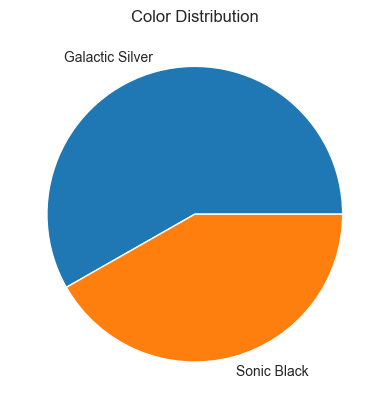

In [6]:
color_counts = df.groupby('color')['title'].count()

print(color_counts)

plt.pie(color_counts.values, labels=color_counts.index)
plt.title('Color Distribution')
# Set the background color to none
plt.axis('off')
plt.show()

color
Galactic Silver    4.200658
Sonic Black        4.213303
Name: rating, dtype: float64


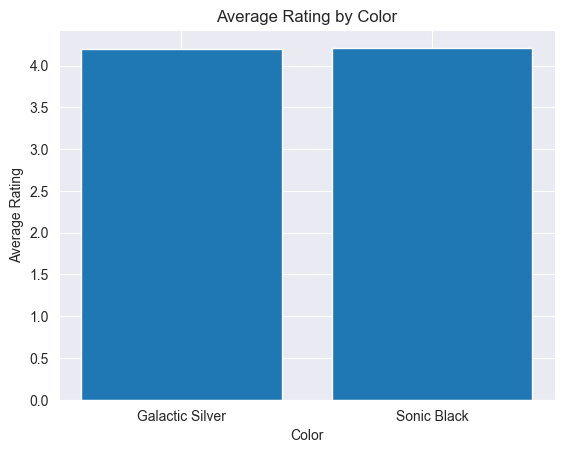

In [7]:
# Group data by color and calculate average rating
color_ratings = df.groupby('color')['rating'].mean()
print(color_ratings)
# Plot bar chart of color vs. average rating
plt.bar(color_ratings.index, color_ratings.values)
plt.xlabel('Color')
plt.ylabel('Average Rating')
plt.title('Average Rating by Color')
plt.show()

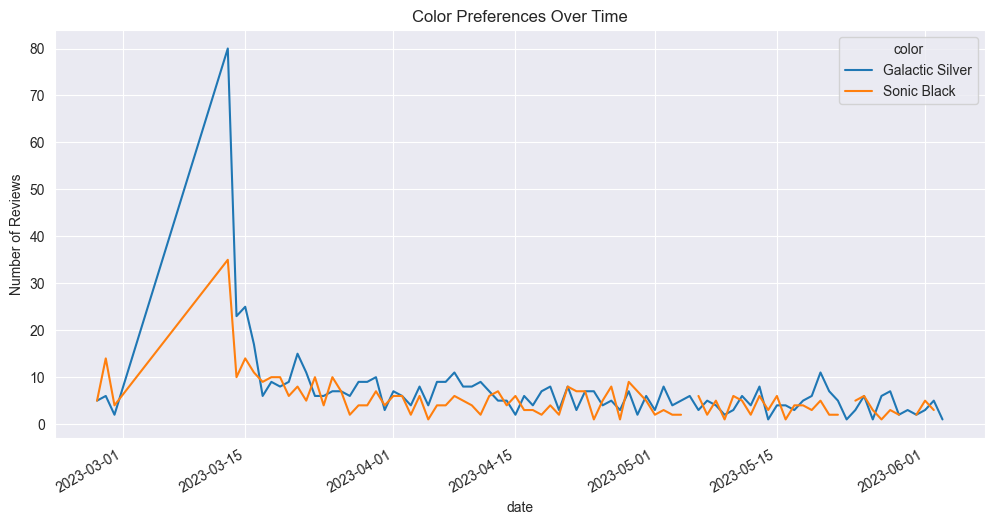

In [8]:
# Extract relevant columns
color_df = df[['color']]

# Group by color and date, count number of entries
color_count = color_df.groupby([pd.Grouper(freq='D'), 'color']).size().reset_index(name='count')

# Pivot the data to make colors into columns
pivoted = color_count.pivot(index='date', columns='color', values='count')

# Plot the data on a line chart
plt.figure(figsize=(12,6))
plt.title('Color Preferences Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
pivoted.plot(kind='line', ax=plt.gca())
plt.show()

   ram  title count
0    8          598
1   16          446


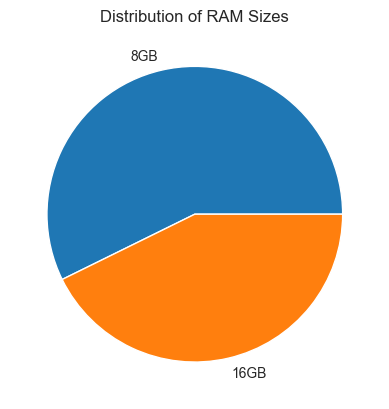

In [9]:
# Group reviews by RAM size and count number of reviews in each group
ram_counts = df.groupby('ram')['title'].count().reset_index(name='title count')
print(ram_counts)
# Filter out rows with no RAM size
ram_counts = ram_counts[~ram_counts['ram'].isna()]
ram_counts['ram'] = ram_counts['ram'].astype(str) + 'GB'
plt.pie(ram_counts['title count'], labels=ram_counts['ram'])
plt.title('Distribution of RAM Sizes')
plt.show()

[4.16555184]
[4.26008969]


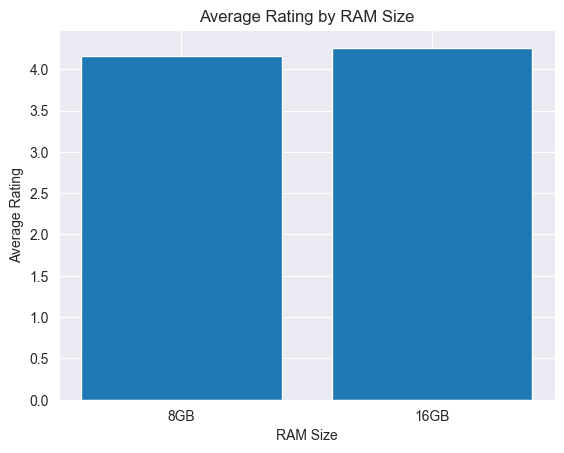

In [10]:
# Group data by RAM size and create two groups: 8 GB RAM and 16 GB RAM
eight_gb_ratings = df[df['ram']==8].groupby('ram')['rating'].mean().values
sixteen_gb_ratings = df[df['ram']==16].groupby('ram')['rating'].mean().values
print(eight_gb_ratings)
print(sixteen_gb_ratings)
# Plot bar chart of RAM size vs. average rating with only two x values
plt.bar(['8GB', '16GB'], [eight_gb_ratings.mean(), sixteen_gb_ratings.mean()])
plt.xlabel('RAM Size')
plt.ylabel('Average Rating')
plt.title('Average Rating by RAM Size')
plt.show()

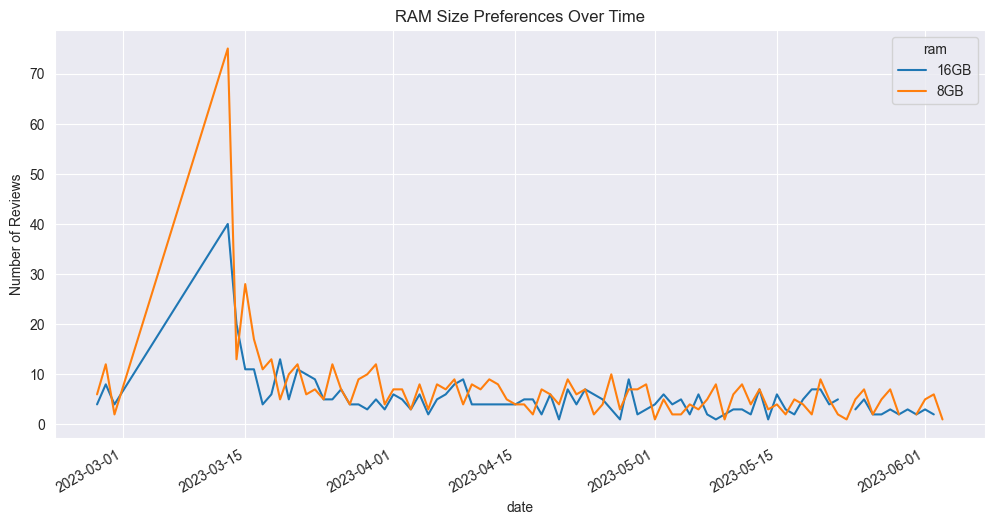

In [11]:
# Extract relevant columns
ram_df = df[['ram']]

# Filter by RAM size of 8 or 16 GB
ram_df = ram_df[(ram_df['ram']==8) | (ram_df['ram']==16)]

# Group by RAM size and date, count number of entries
ram_count = ram_df.groupby([pd.Grouper(freq='D'), 'ram']).size().reset_index(name='count')

ram_count.loc[ram_count.ram == 8, 'ram'] = '8GB'
ram_count.loc[ram_count.ram == 16, 'ram'] = '16GB'

# Pivot the data to make RAM sizes into columns
pivoted = ram_count.pivot(index='date', columns='ram', values='count')

# Plot the data on a line chart
plt.figure(figsize=(12,6))
plt.title('RAM Size Preferences Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
pivoted.plot(kind='line', ax=plt.gca())
plt.show()

rating    1.0  2.0  3.0  4.0  5.0
verified                         
False      24    1   15   25   57
True      102   15   51  120  634


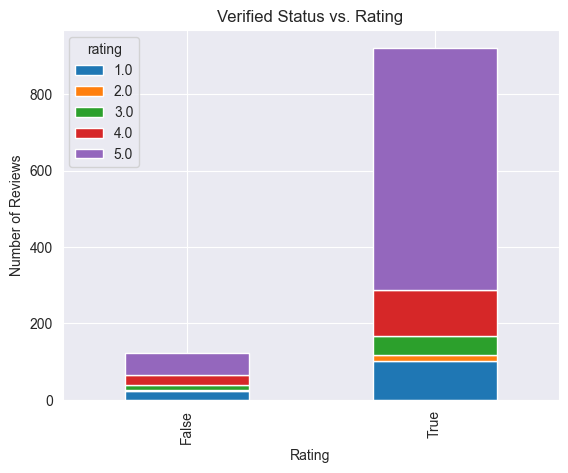

In [12]:
grouped = df.groupby(['verified', 'rating']).size().unstack()
print(grouped)
# plot the grouped bar chart
grouped.plot(kind='bar', stacked=True)

# set the chart title and axis labels
plt.title('Verified Status vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

# display the chart
plt.show()

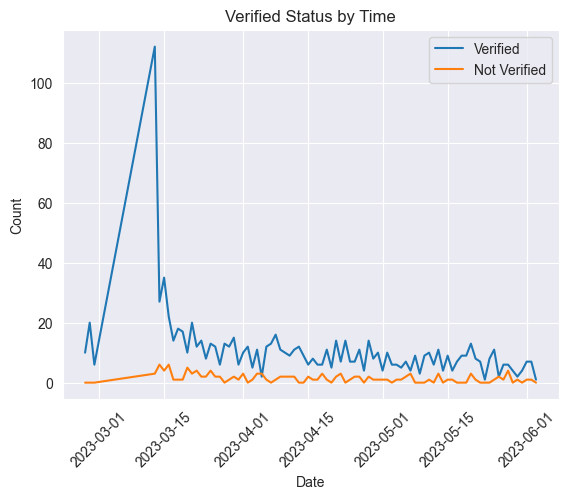

In [13]:
# Group the data by date and verified status and count the number of occurrences
grouped_df = df.groupby([df.index.date, 'verified']).size().unstack(fill_value=0)

# Plot a line graph of the data
plt.plot(grouped_df.index, grouped_df[True], label='Verified')
plt.plot(grouped_df.index, grouped_df[False], label='Not Verified')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Verified Status by Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

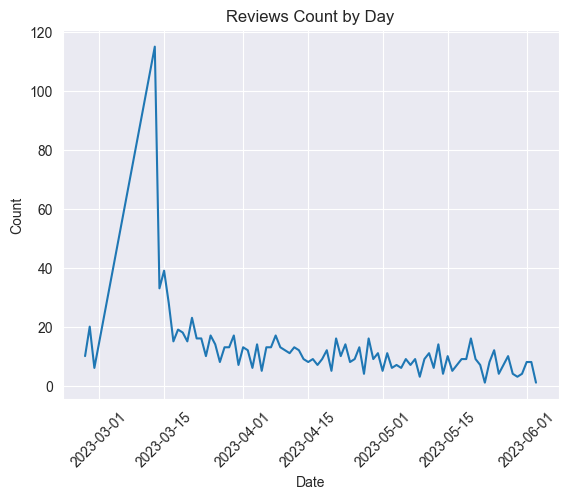

In [14]:
# Count by date
count_by_date = df.groupby('date').size()

# Plot the graph
plt.plot(count_by_date.index, count_by_date.values)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Reviews Count by Day')

# Show the plot
plt.xticks(rotation=45)
plt.show()

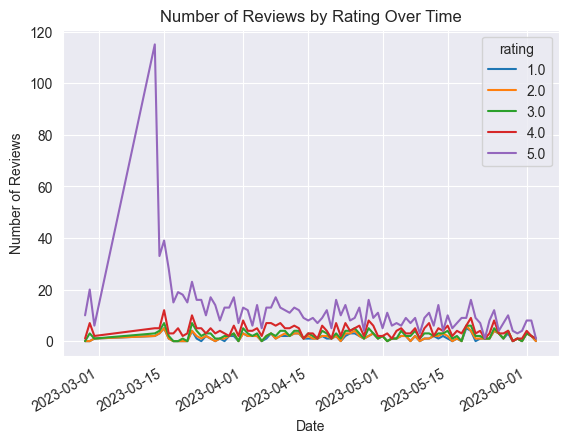

In [15]:
# Group reviews by rating and date, and count the number of reviews in each group
rating_counts = df.groupby([pd.Grouper(freq='D'), 'rating']).size().unstack(fill_value=0)

# Plot the data as a stacked line graph
rating_counts.plot(kind='line', stacked=True)

# Set labels for the x and y axes
plt.xlabel('Date')
plt.ylabel('Number of Reviews')

# Set the title of the graph
plt.title('Number of Reviews by Rating Over Time')

# Display the graph
plt.show()

[ 36 436 323 232  17]
[213.61111111 160.41972477 174.33126935 181.24137931 126.        ]


C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1482710928.py:30: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(45)
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1482710928.py:30: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(45)
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1482710928.py:30: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(45)
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1482710928.py:30: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_rotation(45)
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1482710928.py:30: Matpl

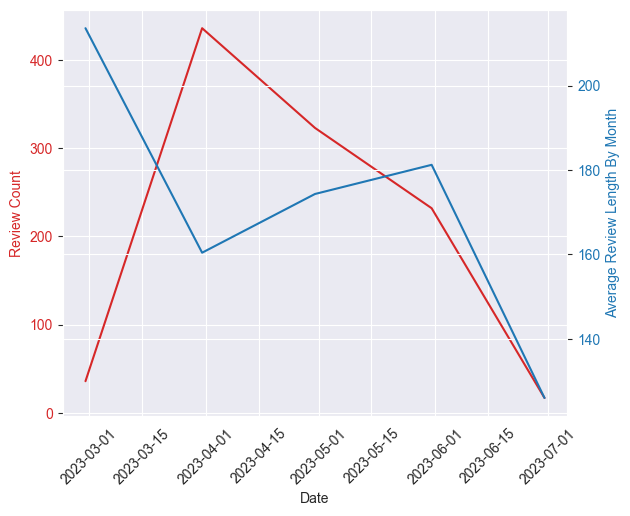

In [16]:
# Group reviews by date
grouped = df.groupby(pd.Grouper(freq='M'))

# Calculate review frequency and length
review_count = grouped.size()
review_length = grouped['body'].apply(lambda x: x.str.len().mean())

# Plot results
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Review Count', color=color)
ax1.plot(review_count.index, review_count.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
print(review_count.values)
print(review_length.values)
ax2.set_ylabel('Average Review Length By Month', color=color)
ax2.plot(review_length.index, review_length.values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# Rotate x-axis tick labels by 90 degrees
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_rotation(45)

plt.show()

rating
5.0    691
4.0    145
3.0     66
1.0    126
2.0     16
Name: count, dtype: int64


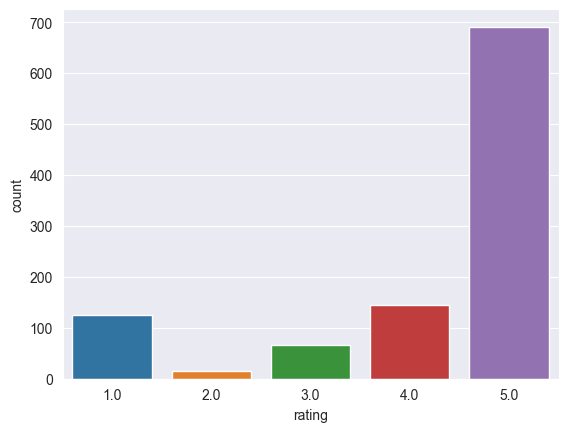

In [17]:
# Define the possible rating values
rating_values = [1.0, 2.0, 3.0, 4.0, 5.0]

# Create the countplot
sns.countplot(x='rating', data=df, order=rating_values)

# Count the number of occurrences of each rating value
rating_counts = df['rating'].value_counts(sort=False)

# Print the result
print(rating_counts)

            rating       ram   storage     color  verified
rating    1.000000  0.034568  0.034568 -0.004610  0.125901
ram       0.034568  1.000000  1.000000  0.001023 -0.011339
storage   0.034568  1.000000  1.000000  0.001023 -0.011339
color    -0.004610  0.001023  0.001023  1.000000 -0.029928
verified  0.125901 -0.011339 -0.011339 -0.029928  1.000000


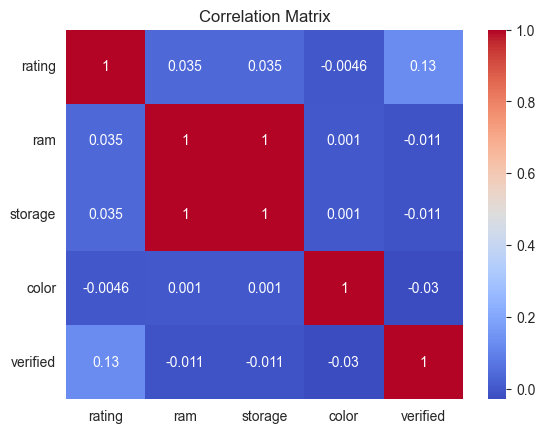

In [18]:
# Create a new DataFrame with modified columns
df_new = df.copy()
# One-hot encoding for the 'color' column
color_dummies = pd.get_dummies(df_new['color'], prefix='color')
df_new = pd.concat([df_new, color_dummies], axis=1)

# Replace color values with -1 or 1
df_new['color'] = df_new['color'].replace({'Galactic Silver': 1, 'Sonic Black': -1})

# Drop 'title' and 'body' columns
df_new.drop(['title', 'body','color_Galactic Silver','color_Sonic Black'], axis=1, inplace=True)

# Correlation matrix between all columns
corr_matrix = df_new.corr()
print(corr_matrix)
# Plotting the heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

In [19]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
df['text'] = df['title'].astype(str) + " " + df['body'].astype(str)
# Compute the sentiment scores for each review
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
# Classify the reviews as positive, neutral, or negative
df['sentiment_class'] = pd.cut(df['sentiment'], bins=3, labels=['negative', 'neutral', 'positive'])

# Print the distribution of sentiment classes
print(df['sentiment_class'].value_counts())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vladz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment_class
positive    810
negative    131
neutral     103
Name: count, dtype: int64


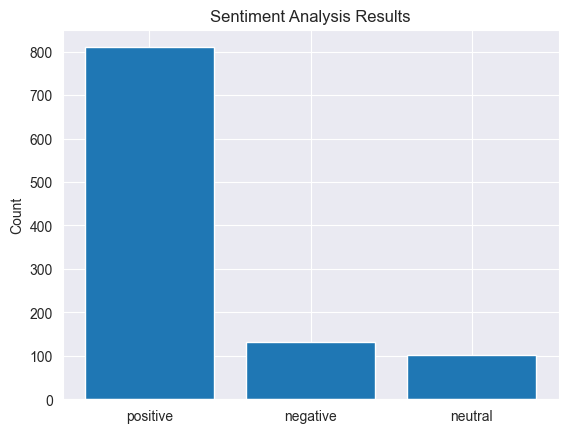

In [20]:
counts = df['sentiment_class'].value_counts()

plt.bar(counts.index, counts.values)

# set the chart title and axis labels
plt.title('Sentiment Analysis Results')
plt.ylabel('Count')
plt.show()

C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\939902941.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['processed_text'] = neg_df['text'].apply(preprocess_text)


['price', 'would', 'money', 'battery', 'problem', 'use', 'camera', 'product', 'phone', 'oneplus']
['replacement', 'camera quality', 'product', 'gaming', 'camera', 'battery', 'display', 'phone', 'good', 'quality']
['one plus', 'also', 'buy', 'worst', 'amazon', 'mobile', 'one', 'service', 'oneplus', 'phone']
['brand', 'problem', 'camera', 'using', 'battery', 'performance', 'good', 'worst', 'mobile', 'phone']
['brand', 'battery', 'killer', 'flagship killer', 'flagship', 'product', 'bad', 'phone', 'oneplus', 'good']


C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


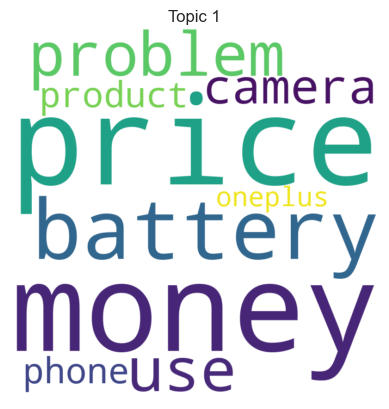

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


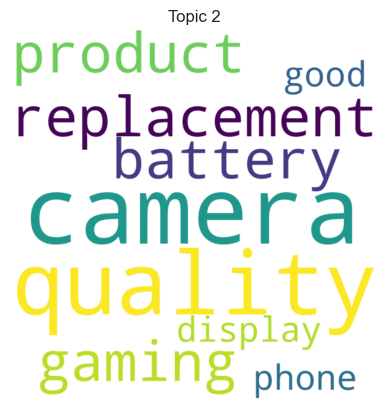

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


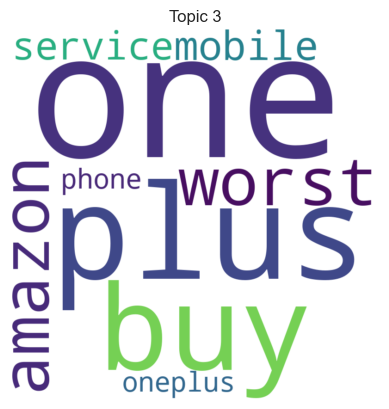

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


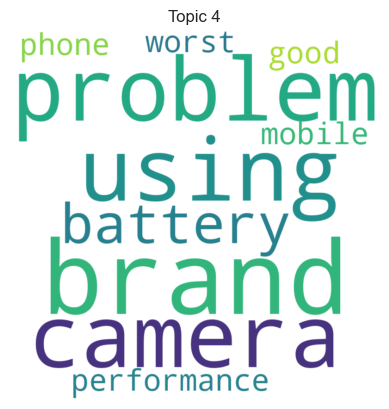

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


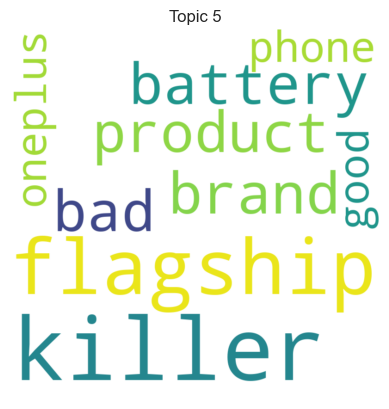

In [21]:
# Create a separate DataFrame with only the negative reviews
neg_df = df[df['sentiment_class'] == 'negative']

# Define a function to preprocess the text data, removing stopwords and converting to lowercase
def preprocess_text(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

# Preprocess the text data in the negative DataFrame
neg_df['processed_text'] = neg_df['text'].apply(preprocess_text)

# Convert the preprocessed text data into a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, ngram_range=(1, 2))
dtm = vectorizer.fit_transform(neg_df['processed_text'])

# Train an LDA model with 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

# Print the top 10 words for each topic
for index, topic in enumerate(lda_model.components_):
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Generate word clouds for each topic
for index, topic in enumerate(lda_model.components_):
    plt.figure()
    wordcloud = WordCloud(background_color="white",width=800, height=800).generate(' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {index+1}")
    plt.show()

C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1112427295.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df[f'Topic {i+1}'] = topic_proportions[:,i]
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1112427295.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df[f'Topic {i+1}'] = topic_proportions[:,i]
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\1112427295.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

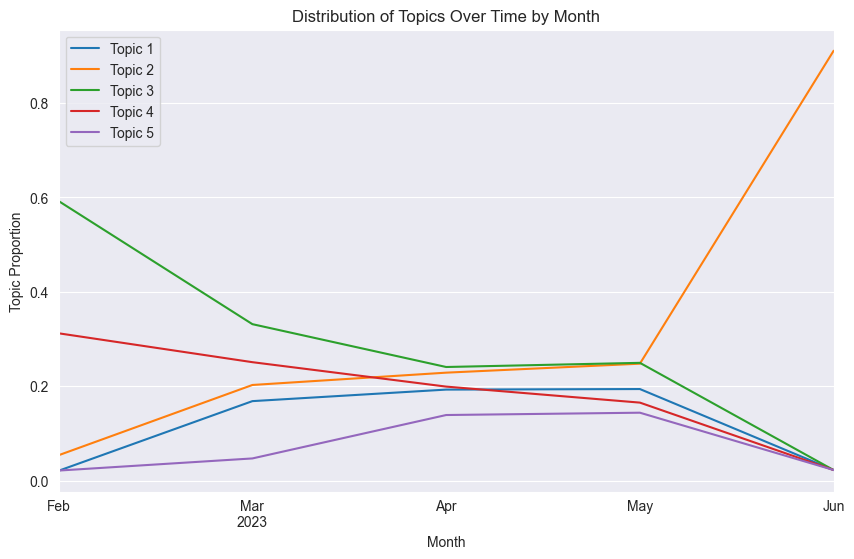

In [22]:
# Get the topic proportions for each document
topic_proportions = lda_model.transform(dtm)

# Create columns for each topic's proportion in the neg_df dataframe
for i in range(lda_model.n_components):
    neg_df[f'Topic {i+1}'] = topic_proportions[:,i]

# Create a pivot table to aggregate the topic proportions by month
neg_df_pivot = neg_df.pivot_table(index=pd.Grouper(freq='M'), values=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'], aggfunc=np.mean)

# Plot the distribution of topics over time
neg_df_pivot.plot(figsize=(10,6))
plt.xlabel('Month')
plt.ylabel('Topic Proportion')
plt.title('Distribution of Topics Over Time by Month')
plt.show()


C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\2216159175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['processed_text'] = pos_df['text'].apply(preprocess_text)


['performance', 'display', 'awesome', 'super', 'oneplus', 'battery', 'quality', 'phone', 'camera', 'best']
['also', 'plus', 'mobile', 'battery', 'like', 'one', 'good', 'camera', 'oneplus', 'phone']
['best phone', 'awesome', 'camera', 'excellent', 'price range', 'great', 'range', 'price', 'best', 'phone']
['best', 'camera', 'quality', 'product', 'value money', 'value', 'money', 'nice', 'phone', 'good']
['good battery', 'display', 'battery life', 'phone', 'life', 'good phone', 'performance', 'camera', 'battery', 'good']


C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


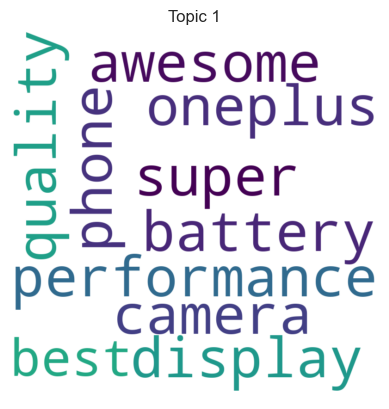

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


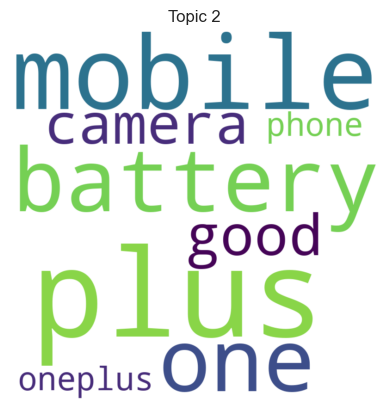

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


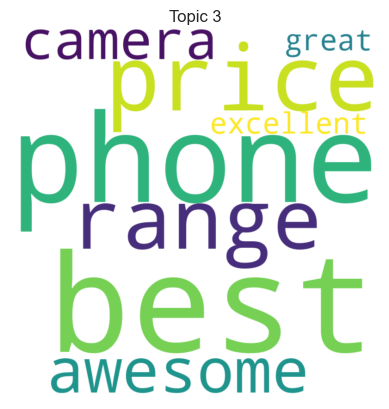

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


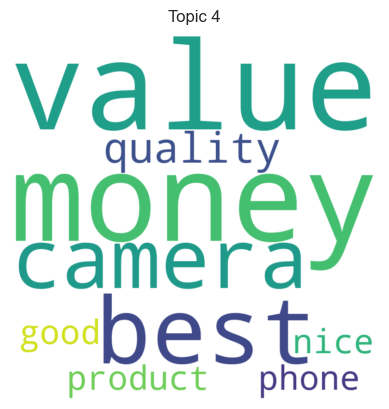

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


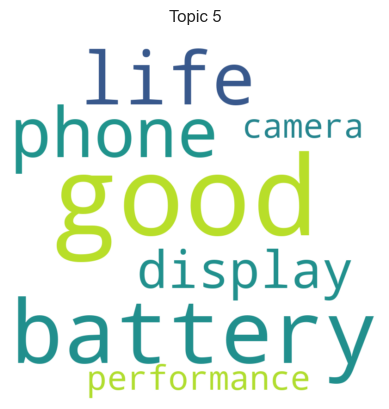

In [23]:
# Create a separate DataFrame with only the positive reviews
pos_df = df[df['sentiment_class'] == 'positive']

# Define a function to preprocess the text data, removing stopwords and converting to lowercase
def preprocess_text(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

# Preprocess the text data in the positive DataFrame
pos_df['processed_text'] = pos_df['text'].apply(preprocess_text)

# Convert the preprocessed text data into a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, ngram_range=(1, 2))
dtm = vectorizer.fit_transform(pos_df['processed_text'])

# Train an LDA model with 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

# Print the top 10 words for each topic
for index, topic in enumerate(lda_model.components_):
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Generate word clouds for each topic
for index, topic in enumerate(lda_model.components_):
    plt.figure()
    wordcloud = WordCloud(background_color="white",width=800, height=800).generate(' '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {index+1}")
    plt.show()


C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\3348714378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df[f'Topic {i+1}'] = topic_proportions[:,i]
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\3348714378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df[f'Topic {i+1}'] = topic_proportions[:,i]
C:\Users\vladz\AppData\Local\Temp\ipykernel_8768\3348714378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

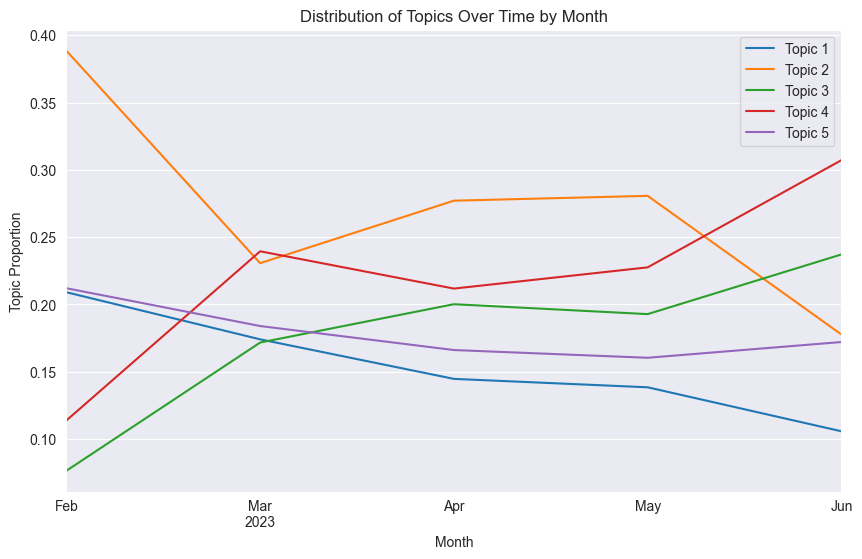

In [24]:
# Get the topic proportions for each document
topic_proportions = lda_model.transform(dtm)

# Create columns for each topic's proportion in the pos_df dataframe
for i in range(lda_model.n_components):
    pos_df[f'Topic {i+1}'] = topic_proportions[:,i]

# Create a pivot table to aggregate the topic proportions by month
pos_df_pivot = pos_df.pivot_table(index=pd.Grouper(freq='M'), values=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'], aggfunc=np.mean)

# Plot the distribution of topics over time
pos_df_pivot.plot(figsize=(10,6))
plt.xlabel('Month')
plt.ylabel('Topic Proportion')
plt.title('Distribution of Topics Over Time by Month')
plt.show()

In [25]:
cont_table = pd.crosstab(df['sentiment_class'], df['verified'])
print(cont_table)

verified         False  True 
sentiment_class              
negative            25    106
neutral             15     88
positive            82    728


In [26]:
chi2, pval, dof, expected = chi2_contingency(cont_table)

print("Chi-square statistic:", chi2)
print("p-value:", pval)

Chi-square statistic: 9.68958155131102
p-value: 0.007869263724305051


In [27]:
# create a TfidfVectorizer object
tfidf = TfidfVectorizer()

# fit and transform the text column into a matrix of tf-idf features
tfidf_matrix = tfidf.fit_transform(df['text'])

In [28]:

# Perform one-hot encoding on selected columns
onehot_df = pd.get_dummies(df[['color', 'verified']], prefix='', prefix_sep='')

# Add a new column for storage values 128 and 256
onehot_df['storage_128'] = (df['storage'] == 128).astype(int)
onehot_df['storage_256'] = (df['storage'] == 256).astype(int)

# Separate rating into individual columns
rating_columns = pd.get_dummies(df['rating'], prefix='rating')
onehot_df = pd.concat([onehot_df, rating_columns], axis=1)

# perform association rule mining with a minimum support of 0.01 and a minimum confidence of 0.5
frequent_itemsets = apriori(onehot_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# print the top 10 rules sorted by lift
rules.sort_values('lift', ascending=False).head(15)

C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
95,"(rating_3.0, Sonic Black)",(storage_128),0.025862,0.572797,0.021073,0.814815,1.422520,0.006259,2.306897,0.304907
130,"(verified, rating_3.0, Sonic Black)",(storage_128),0.020115,0.572797,0.016284,0.809524,1.413282,0.004762,2.242816,0.298430
62,(rating_2.0),"(storage_128, verified)",0.015326,0.507663,0.010536,0.687500,1.354245,0.002756,1.575479,0.265653
23,(rating_2.0),(storage_128),0.015326,0.572797,0.011494,0.750000,1.309365,0.002716,1.708812,0.239948
90,"(storage_256, rating_3.0)",(Galactic Silver),0.019157,0.582375,0.014368,0.750000,1.287829,0.003211,1.670498,0.227865
61,"(verified, rating_2.0)",(storage_128),0.014368,0.572797,0.010536,0.733333,1.280268,0.002307,1.602011,0.222104
120,"(verified, storage_256, rating_3.0)",(Galactic Silver),0.014368,0.582375,0.010536,0.733333,1.259211,0.002169,1.566092,0.208852
142,"(verified, storage_256, rating_4.0)",(Sonic Black),0.044061,0.417625,0.022989,0.521739,1.249302,0.004587,1.217694,0.208751
131,"(rating_3.0, Sonic Black)","(storage_128, verified)",0.025862,0.507663,0.016284,0.629630,1.240252,0.003154,1.329310,0.198855
64,"(verified, rating_3.0)",(storage_128),0.048851,0.572797,0.034483,0.705882,1.232343,0.006501,1.452490,0.198221


In [29]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['rating'], test_size=0.2, random_state=42)

# perform oversampling on the training data to balance the classes
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# create a logistic regression model
lr = LogisticRegression(random_state=42)


# perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
# print the best hyperparameters found by grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)

# predict ratings for testing data using the trained model with the best hyperparameters
y_pred = grid_search.predict(X_test)

# calculate accuracy score for predictions
print(classification_report(y_test, y_pred))

Best Hyperparameters:
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         1.0       0.68      0.65      0.67        26
         2.0       0.00      0.00      0.00         4
         3.0       0.13      0.15      0.14        13
         4.0       0.30      0.23      0.26        35
         5.0       0.80      0.86      0.83       131

    accuracy                           0.67       209
   macro avg       0.38      0.38      0.38       209
weighted avg       0.64      0.67      0.65       209



C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

[[ 17   0   2   2   5]
 [  1   0   2   0   1]
 [  5   0   2   2   4]
 [  2   0   6   8  19]
 [  0   0   3  15 113]]


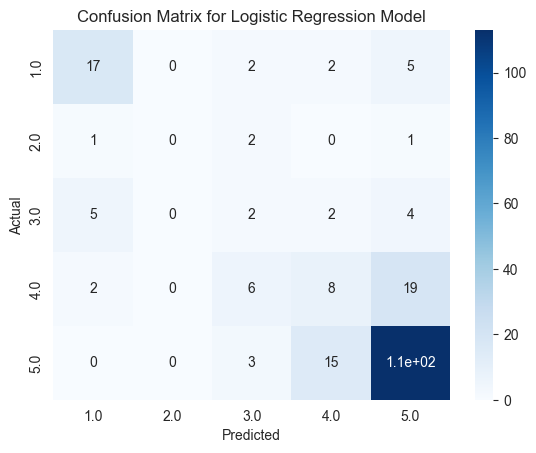

In [30]:
# generate confusion matrix for predicted vs actual sentiment_class
cm = confusion_matrix(y_test, y_pred)
print(cm)
stick_labels = ['1.0', '2.0', '3.0', '4.0','5.0']
# plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=stick_labels, yticklabels=stick_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

In [31]:
# define the parameter distribution for randomized search
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

# create a random forest classifier model
rf = RandomForestClassifier(random_state=42)

# perform randomized search with cross-validation to find the best hyperparameters for random forest
random_search_rf = RandomizedSearchCV(rf, param_dist_rf, n_iter=10, cv=5, random_state=42)
random_search_rf.fit(X_train_resampled, y_train_resampled)

# print the best hyperparameters found by randomized search for random forest
print("Best Hyperparameters for Random Forest:")
print(random_search_rf.best_params_)

# predict ratings for testing data using the trained model with the best hyperparameters
y_pred_rf = random_search_rf.predict(X_test)

# calculate accuracy score for predictions for random forest
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Best Hyperparameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': None}
Classification Report for Random Forest:
              precision    recall  f1-score   support

         1.0       0.69      0.69      0.69        26
         2.0       0.00      0.00      0.00         4
         3.0       0.17      0.08      0.11        13
         4.0       0.44      0.23      0.30        35
         5.0       0.78      0.95      0.86       131

    accuracy                           0.72       209
   macro avg       0.42      0.39      0.39       209
weighted avg       0.66      0.72      0.68       209



C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

[[ 17   0   2   2   5]
 [  1   0   2   0   1]
 [  5   0   2   2   4]
 [  2   0   6   8  19]
 [  0   0   3  15 113]]


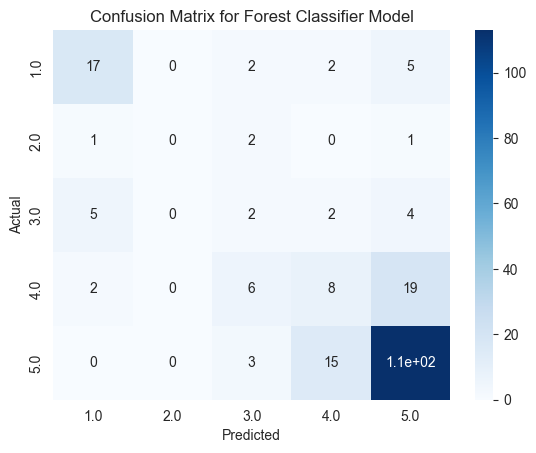

In [32]:
# generate confusion matrix for predicted vs actual sentiment_class
cm = confusion_matrix(y_test, y_pred)
print(cm)
stick_labels = ['1.0', '2.0', '3.0', '4.0','5.0']
# plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=stick_labels, yticklabels=stick_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Forest Classifier Model')
plt.show()

In [33]:
# define the parameter distribution for randomized search
param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

# create a gradient boosting classifier model
gb = GradientBoostingClassifier(random_state=42)

# perform randomized search with cross-validation to find the best hyperparameters for gradient boosting
random_search_gb = RandomizedSearchCV(gb, param_dist_gb, n_iter=3, cv=5, random_state=42)
random_search_gb.fit(X_train_resampled, y_train_resampled)

# print the best hyperparameters found by randomized search for gradient boosting
print("Best Hyperparameters for Gradient Boosting:")
print(random_search_gb.best_params_)

# predict ratings for testing data using the trained model with the best hyperparameters
y_pred_gb = random_search_gb.predict(X_test)

# calculate accuracy score for predictions for gradient boosting
print("Classification Report for Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

Best Hyperparameters for Gradient Boosting:
{'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

         1.0       0.70      0.54      0.61        26
         2.0       0.00      0.00      0.00         4
         3.0       0.12      0.15      0.13        13
         4.0       0.33      0.34      0.34        35
         5.0       0.80      0.83      0.82       131

    accuracy                           0.66       209
   macro avg       0.39      0.37      0.38       209
weighted avg       0.65      0.66      0.65       209



C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

[[ 17   0   2   2   5]
 [  1   0   2   0   1]
 [  5   0   2   2   4]
 [  2   0   6   8  19]
 [  0   0   3  15 113]]


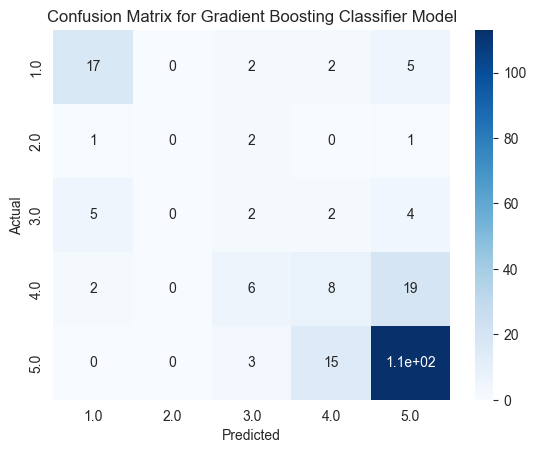

In [34]:
# generate confusion matrix for predicted vs actual sentiment_class
cm = confusion_matrix(y_test, y_pred)
print(cm)
stick_labels = ['1.0', '2.0', '3.0', '4.0','5.0']
# plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=stick_labels, yticklabels=stick_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Classifier Model')
plt.show()

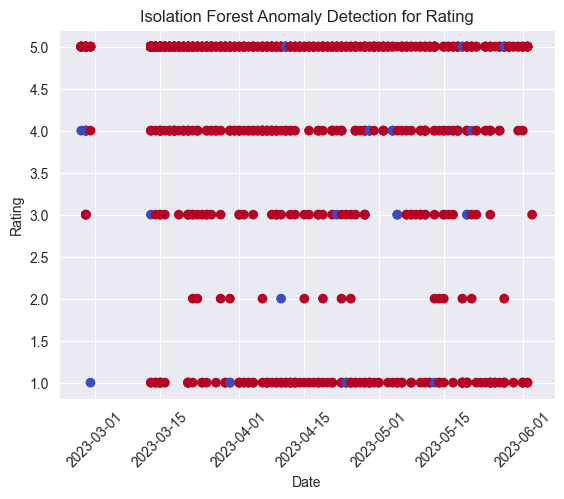

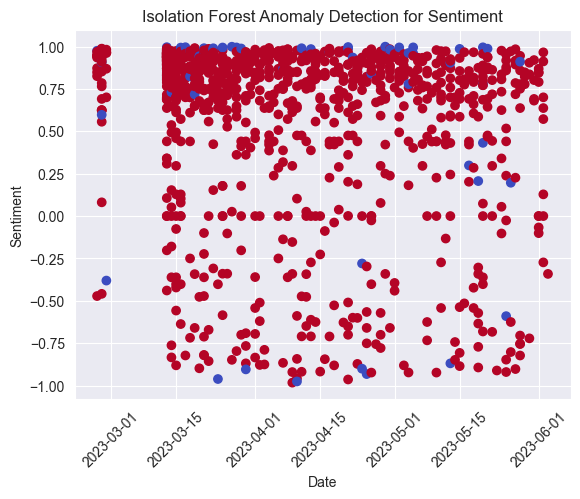

In [35]:
# Extracting features from text using TD-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df['text'])

# Selecting rating and sentiment columns
X_rating_sentiment = df[['rating', 'sentiment']].values

# Concatenating the features
X = np.concatenate((X_text.toarray(), X_rating_sentiment), axis=1)

# Applying Isolation Forest algorithm
clf = IsolationForest(random_state=42, contamination=0.05)
clf.fit(X)

# Predicting outliers
outliers = clf.predict(X)

# Plotting the results
plt.scatter(df.index, df['rating'], c=outliers, cmap='coolwarm')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.title('Isolation Forest Anomaly Detection for Rating')
plt.xticks(rotation=45)
plt.show()

plt.scatter(df.index, df['sentiment'], c=outliers, cmap='coolwarm')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Isolation Forest Anomaly Detection for Sentiment')
plt.xticks(rotation=45)
plt.show()

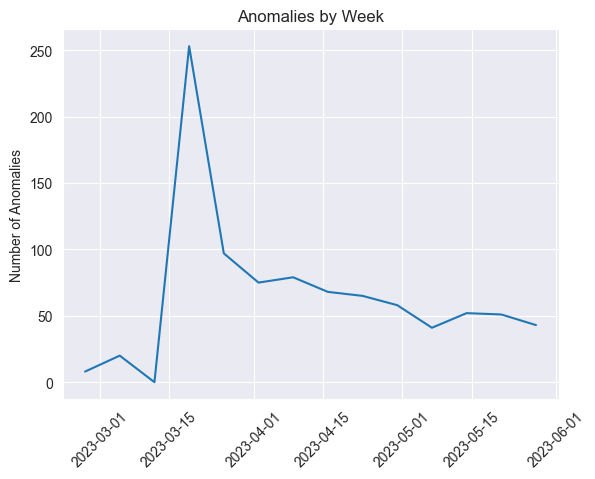

In [36]:
# Counting the number of anomalies in each week
df['anomaly'] = outliers
anomalies_by_week = df.resample('W')['anomaly'].sum()

# Removing the last row (partial week)
anomalies_by_week = anomalies_by_week.iloc[:-1]

# Plotting the results
plt.plot(anomalies_by_week)
plt.ylabel('Number of Anomalies')
plt.title('Anomalies by Week')
plt.xticks(rotation=45)
plt.show()

In [37]:
# Sorting the weeks by number of anomalies in descending order
sorted_weeks = anomalies_by_week.sort_values(ascending=False)

# Selecting the week with the most anomalies
most_anomalies_week = sorted_weeks.index[0]

# Printing the week with the most anomalies
print('Week with the most anomalies:', most_anomalies_week)

Week with the most anomalies: 2023-03-19 00:00:00


In [38]:
# Selecting the reviews from the week with the most anomalies
start_date = most_anomalies_week - pd.Timedelta(days=7)
end_date = most_anomalies_week
anomaly_reviews = df[(df.index >= start_date) & (df.index <= end_date)]['text']

Top words for topic #1
['display', 'battery', 'quality', 'awesome', 'mobile', 'oneplus', 'camera', 'best', 'good', 'phone']


Top words for topic #2
['totally', 'looks', 'delivery', 'sound', 'amazon', 'phone', 'experience', 'fabulous', 'beautiful', 'good']


Top words for topic #3
['performance', 'camera', 'looking', 'processor', 'battery', 'best', '10', 'fast', 'phone', 'good']


Top words for topic #4
['flagship', 'love', 'money', 'camera', 'quality', 'gaming', 'oneplus', 'great', 'best', 'phone']


Top words for topic #5
['usage', 'stylish', 'light', 'heating', 'fast', 'good', 'best', 'performance', 'battery', 'phone']


Average sentiment of anomaly reviews: 0.53355078648057


C:\Users\vladz\PycharmProjects\data-analizing\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


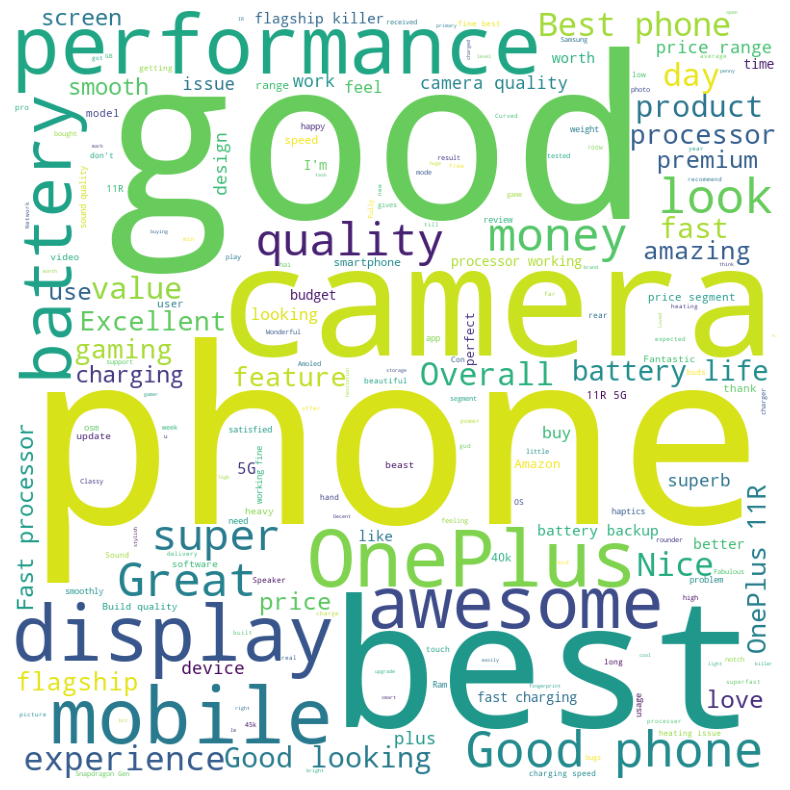

In [39]:
# Selecting the reviews from the week with the most anomalies
start_date = most_anomalies_week - pd.Timedelta(days=7)
end_date = most_anomalies_week
anomaly_reviews = df[(df.index >= start_date) & (df.index <= end_date)]['text']

# Topic modeling using LDA
n_topics = 5
vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(anomaly_reviews)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Print top words for each topic
for i, topic in enumerate(lda.components_):
    print(f"Top words for topic #{i+1}")
    print([vec.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print('\n')

# Sentiment analysis using TextBlob
anomaly_sentiments = [TextBlob(review).sentiment.polarity for review in anomaly_reviews]
print("Average sentiment of anomaly reviews:", sum(anomaly_sentiments)/len(anomaly_sentiments))

# Creating a word cloud
words = ' '.join(list(anomaly_reviews))
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOP_WORDS).generate(words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()